#Mounting & Importing Libraries

In [1]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt

In [4]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.6 MB 13.1 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 133 kB 51.8 MB/s 
     |████████████████████████████████| 170 kB 50.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import importlib
#importlib.reload(MyFunctions)
import MyFunctions

#Model
Which is explained very clearly [here](https://neurohive.io/en/popular-networks/vgg16/)

##Inputs

In [6]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32  

In [8]:
df_train=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
df_test=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [10]:
datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255)
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = datagen.flow_from_dataframe(
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [11]:
valid_batches = datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


## Model Definition

In [12]:
model = models.Sequential()
conv_base = VGG16(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  
conv_base.trainable = False 
model.add(conv_base)
model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation="relu")) 
model.add(layers.Dense(NUM_CLASSES, activation="softmax")) 

##Compilation & Trainning

In [14]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
# Initialize wandb with your project name
run = wandb.init(project='filter',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 100,
                     "batch_size": 32,
                     "Transfer Learning":"No",
                     "loss_function": "categorical_crossentropy",
                     "architecture": "VGG - 16",
                     "dataset": "PA-AP-L"
                 })
config = wandb.config

wandb: Currently logged in as: eberrino (use `wandb login --relogin` to force relogin)


In [16]:
history=model.fit(train_batches, 
                  validation_data = valid_batches,
                  epochs= 100,
                  workers=10,
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),WandbCallback()],
                  batch_size = BATCH_SIZE 
 )
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/VGG_NoTL.h5')

Epoch 1/100
436/436 [==============================] - 935s 2s/step - loss: 0.8765 - accuracy: 0.6247 - val_loss: 0.7787 - val_accuracy: 0.6106
Epoch 2/100
436/436 [==============================] - 121s 273ms/step - loss: 0.7327 - accuracy: 0.6260 - val_loss: 0.7072 - val_accuracy: 0.6106
Epoch 3/100
436/436 [==============================] - 113s 255ms/step - loss: 0.6564 - accuracy: 0.6582 - val_loss: 0.6201 - val_accuracy: 0.7410
Epoch 4/100
436/436 [==============================] - 109s 246ms/step - loss: 0.5659 - accuracy: 0.8283 - val_loss: 0.5250 - val_accuracy: 0.8859
Epoch 5/100
436/436 [==============================] - 109s 246ms/step - loss: 0.4773 - accuracy: 0.9005 - val_loss: 0.4415 - val_accuracy: 0.9108
Epoch 6/100
436/436 [==============================] - 109s 246ms/step - loss: 0.4046 - accuracy: 0.9189 - val_loss: 0.3768 - val_accuracy: 0.9211
Epoch 7/100
436/436 [==============================] - 107s 242ms/step - loss: 0.3505 - accuracy: 0.9245 - val_loss: 0.33

Early Stopping --> monitor 'val_loss' or 'accuracy_loss'
[More Info](http://alexadam.ca/ml/2018/08/03/early-stopping.html#:~:text=Problems%20With%20Early%20Stopping,increase%20as%20validation%20loss%20decreases.&text=The%20issue%20is%20that%20validation,worse%20as%20validation%20accuracy%20improves.) 

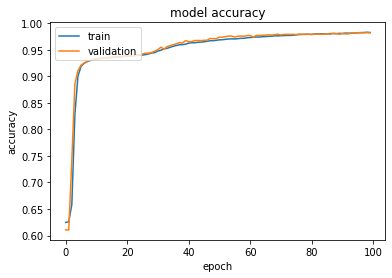

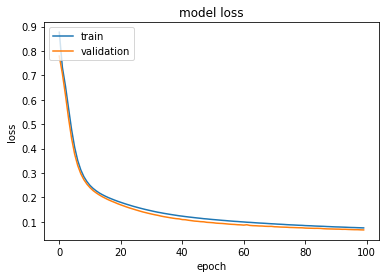

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Test

In [18]:
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
test_datagen = ImageDataGenerator(rescale = 1./255)
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical",#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/VGG_NoTL.h5')

In [19]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 2192s 503ms/step
(4360, 3)


In [20]:
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/01. VGG-19/Results/No TL/result_test_crude.csv')

In [21]:
#Obtenemos el nombre de clase asociado a cada indice 
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [22]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils/')
import MyFunctions

In [23]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2728
L                1447
AP_horizontal     185
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.90      0.76      0.83       217
            L       0.98      1.00      0.99      1427
           PA       0.98      0.99      0.99      2716

     accuracy                           0.98      4360
    macro avg       0.95      0.92      0.93      4360
 weighted avg       0.98      0.98      0.98      4360



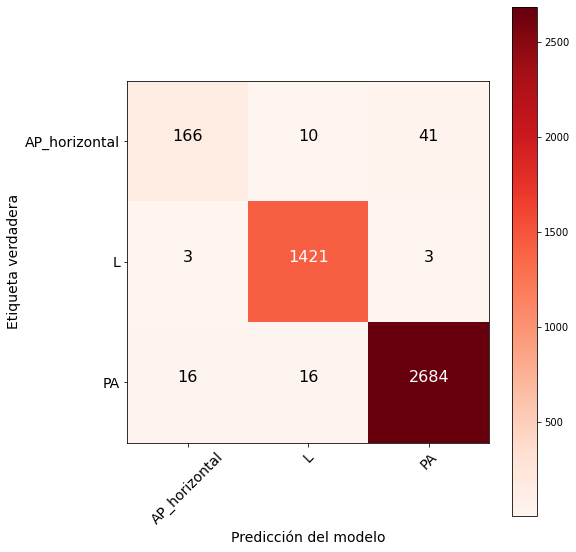

In [24]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/01. VGG-19/Results/No TL/Images/CM_Filtro_Unico')

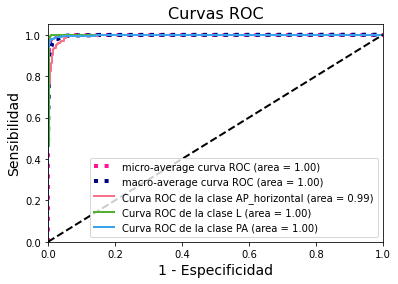

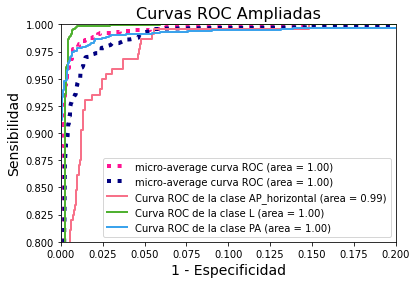

In [25]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/01. VGG-19/Results/No TL/Images/ROC_Filtro_Unico')

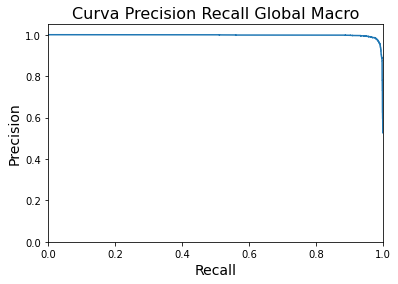

In [26]:
MyFunctions.precision_recall_global(result_test,gts,NUM_CLASSES,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/01. VGG-19/Results/No TL/Images/PRG_Filtro_Unico')

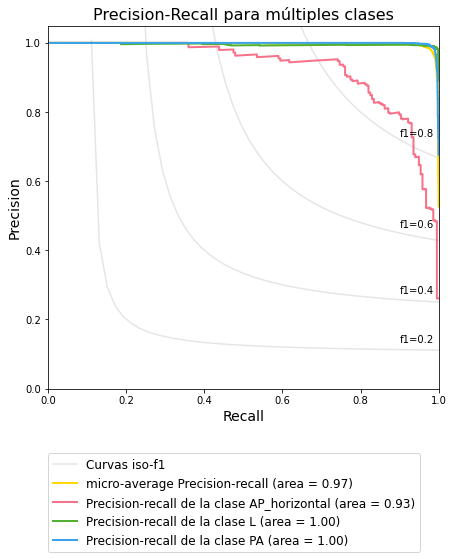

In [27]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/01. VGG-19/Results/No TL/Images/PRM_Filtro_Unico')

In [28]:
df_test["Pred"] = preds_classes

In [29]:
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA


In [30]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


In [31]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/01. VGG-19/Results/No TL/result_test_final.csv')

#[Model Evaluation - Metrics](https://https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826)
Para poder comparar diferentes modelos, debemos escoger una única metrica principal. En este nos quedamos con el F1 - score, que tiene la ventaja de incluir precision y recall. 


*   **Precision o Valor Predictivo Positivo (VPP):** Imágenes pertenecientes a un grupo/ Imágenes clasificados como pertenecientes a ese grupo. (TP/TP+FP)
*   **Recall o Sensibilidad:** (TP/TP+FN)
*   **F1 - Score**
 
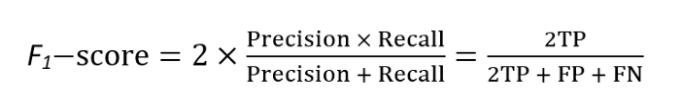



Para una clasificación no binaria, tenemos diferentes maneras de incorporar los resultados en una única métrica: 
*   Micro F1
*   Macro F1: Promedio Normal entre clases
*   F1 Ponderada: Promedio ponderado (entre clases, según la cantidad de imágenes por clase o algún otro criterio, por ejemplo a que clase le queremos dar mayor importancia).

##[AUC - ROC Curve](https://https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
AUC: Area under the curve.
ROC: Reciever Operating Caracteristics.
Nos da la capacidad del modelo de distinguir entre clases. Cuanto mayor es el AUC (máx. = 1), mejor clasifica. Si vale 0.5, implica que el modelo no tiene capacidad de clasificar.

Para un modelo multiclase, debemos usar la metodología uno vs todos, es decir, un gráfico por clase.